# Livingston (KLVM, MTELV, MTLWM) ProbGust Reliablity

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### load_forecast_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [10]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    left_data = left.copy(deep=True)
    left_data.columns = ['{0:s}_{1:s}'.format(x, left_prefix) for x in left_data.columns]
    right_data = right.copy(deep=True)
    right_data.columns = ['{0:s}_{1:s}'.format(x, right_prefix) for x in right_data.columns]
    return pd.merge(left_data, right_data, how='inner', left_on='{0:s}_{1:s}'.format(left_time, left_prefix), right_on='{0:s}_{1:s}'.format(right_time, right_prefix)).reset_index()

### filter_three_hourly
Filter NBM data to 3 hourly forecast

In [11]:
def filter_three_hourly(data, time_field='valid_time'):
    return data[data.index.get_level_values(time_field).hour % 3 == 0]

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [12]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### standard_error_of_estimate
calculate the standard error from a slope and intercept

In [13]:
def standard_error_of_estimate(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    error = np.inf
    if len(x) > 2:
        error = np.sqrt(np.sum(((slope * x + intercept) - y)**2) / (len(x) - 2))
    return error

### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [14]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

### load_operational_probability
Load the operational probability for the time-lagged wind guidance

In [15]:
def load_operational_probability():
    previous_data = xr.open_dataset('../data/database/MOSDATA.nc').to_dataframe()
    previous_data = previous_data[(previous_data.stn == 'KLVM') & (previous_data.model == 'MAV') & np.isfinite(previous_data.run) & np.isfinite(previous_data.valid) & (previous_data.valid >= pd.to_datetime('2020-09-30T18:00:00Z').to_datetime64())][['run', 'valid', 'WDR', 'WSP']].set_index(['run', 'valid']).sort_index()

    subadvisory_matrix = xr.open_dataset('../data/database/LVMSubmatrix_MAV.nc').to_dataframe()
    advisory_matrix = xr.open_dataset('../data/database/LVMmatrix.nc').to_dataframe()
    warning_matrix = xr.open_dataset('../data/database/LVMWarnmatrix.nc').to_dataframe()

    previous_data['MaxSub'] = pd.merge(right=previous_data.reset_index(), left=subadvisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
    previous_data.MaxSub= previous_data.MaxSub.fillna(999)

    previous_data['MaxAdv'] = pd.merge(right=previous_data.reset_index(), left=advisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
    previous_data.MaxAdv = previous_data.MaxAdv.fillna(999)

    previous_data['MaxWarn'] = pd.merge(right=previous_data.reset_index(), left=warning_matrix.groupby(['DIR']).WS.max().reset_index(), right_on='WDR', left_on='DIR', how='right').set_index(['run', 'valid']).sort_index()['WS']
    previous_data.MaxWarn = previous_data.MaxWarn.fillna(999)

    previous_data['SubSpeed'] = previous_data[['WSP', 'MaxSub']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_50'] = pd.merge(right=previous_data.reset_index(), left=subadvisory_matrix, right_on=['WDR', 'SubSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
    previous_data.Raw_50 = previous_data.Raw_50.fillna(0)

    previous_data['AdvSpeed'] = previous_data[['WSP', 'MaxAdv']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_58'] = pd.merge(right=previous_data.reset_index(), left=advisory_matrix, right_on=['WDR', 'AdvSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
    previous_data.Raw_58 = previous_data.Raw_58.fillna(0)

    previous_data['WarnSpeed'] = previous_data[['WSP', 'MaxWarn']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_75'] = pd.merge(right=previous_data.reset_index(), left=warning_matrix, right_on=['WDR', 'WarnSpeed'], left_on=['DIR', 'WS'], how='right').groupby(['run', 'valid'])['Prob'].max()
    previous_data.Raw_75 = previous_data.Raw_75.fillna(0)

    previous_data = previous_data.reset_index()[['run', 'valid', 'Raw_50', 'Raw_58', 'Raw_75']]
    previous_data.columns = ['reference_time', 'valid_time', 'Raw_50', 'Raw_58', 'Raw_75']
    previous_data = previous_data.set_index(['reference_time', 'valid_time']).sort_index()

    previous_data[[x.replace('Raw', 'Operational') for x in ['Raw_50', 'Raw_58', 'Raw_75']]] = pd.concat([expand_timelag(previous_data, '{0:d}H'.format(i*6)) for i in range(12)]).groupby(['reference_time', 'valid_time']).mean()[['Raw_50', 'Raw_58', 'Raw_75']]
    return previous_data[[x for x in previous_data.columns if x.find('Operational_') > -1]]

### load_nbm_prob_gust
apply bias-correction and calculate ProbGust

In [16]:
def load_nbm_prob_gust(siteID, regression, thresholds, mean='10_meter_wind_speed_of_gust_mean', spread='10_meter_wind_speed_of_gust_standard_deviation'):
    nbm_data = load_forecast_grid('../data/nbm/NBM_{0:s}.nc'.format(siteID), filter_fields=[mean, spread])
    nbm_data = filter_missing_data(nbm_data)
    nbm_data[mean] = regression.slope[siteID] * nbm_data[mean] + regression.intercept[siteID]
    for threshold in thresholds:
        nbm_data['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_data, threshold)
    return nbm_data[[col for col in nbm_data.columns if col.find('ProbGust') > -1]]

### load_wind_gust_observation
load the wind gust, optionally filling with wind speed if gust is missing and applying a correction

In [17]:
def load_wind_gust_observation(siteID, wind_speed='10_meter_wind_speed', wind_gust='10_meter_wind_speed_of_gust', correction=None):
    obs_data = load_observations('../data/observations/{0:s}.nc'.format(siteID), 
                                 filter_fields=[x for x in [wind_speed, wind_gust] if x is not None])
    if wind_speed is not None:
        replace_missing_gust_with_wind(obs_data, wind_speed, wind_gust)
    obs_data = obs_data[[wind_gust]].reset_index().set_index('time')
    if correction is not None:
        obs_data = correction(obs_data)
    return filter_missing_data(obs_data)

## Read Bias-Correction parameters

In [18]:
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
LVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934
UMHM,0.695138,9.328585,0.715288,1.233256e-229,0.017768


## Load Observations

In [19]:
obs = pd.concat([ load_wind_gust_observation(x) for x in ['MTLWM', 'MTELV', 'LVM']]).sort_values(['time']).groupby(['time']).max()
obs

,10_meter_wind_speed_of_gust
time,
2020-05-18 00:00:00,5.144444
2020-05-18 00:05:00,4.630000
2020-05-18 00:10:00,4.630000
2020-05-18 00:15:00,4.115556
2020-05-18 00:20:00,3.601111
...,...
2021-05-01 05:30:00,3.040000
2021-05-01 05:38:00,1.920000
2021-05-01 05:45:00,1.920000


## Load NBM Datasets
also create subsets for short and long term and filter data to 3 hourly for full NBM

In [20]:
nbm = pd.concat([load_nbm_prob_gust(x, regression, [50, 58, 75]).reset_index() for x in ['MTLWM', 'MTELV', 'LVM']]).groupby(['reference_time', 'valid_time']).max()
nbm_short = nbm[(nbm.index.get_level_values(1) - nbm.index.get_level_values(0)).total_seconds()/3600 <= 36].copy(deep=True)
nbm_short.columns = [x.replace('ProbGust', 'ShortProbGust') for x in nbm_short.columns]
nbm_long = nbm[(nbm.index.get_level_values(1) - nbm.index.get_level_values(0)).total_seconds()/3600 >= 36].copy(deep=True)
nbm_long.columns = [x.replace('ProbGust', 'LongProbGust') for x in nbm_long.columns]
nbm = filter_three_hourly(nbm)
nbm

ProbGust_50  ProbGust_58  ProbGust_75
reference_time      valid_time                                                
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0          0.0          0.0
                    2020-10-01 15:00:00          0.0          0.0          0.0
                    2020-10-01 18:00:00          0.0          0.0          0.0
                    2020-10-01 21:00:00          0.0          0.0          0.0
                    2020-10-02 00:00:00          0.0          0.0          0.0
...                                              ...          ...          ...
2021-03-27 09:00:00 2021-04-02 21:00:00          0.0          0.0          0.0
                    2021-04-03 00:00:00          0.0          0.0          0.0
                    2021-04-03 03:00:00          0.0          0.0          0.0
                    2021-04-03 06:00:00          1.0          0.0          0.0
                    2021-04-03 09:00:00          0.0          0.0          0.0

[16798 rows x 3 columns]

## Load Operation Probability Guidance

In [21]:
previous = load_operational_probability()
previous

Operational_50  Operational_58  \
reference_time      valid_time                                            
2020-09-27 18:00:00 2020-09-30 18:00:00        0.000000             0.0   
2020-09-28 00:00:00 2020-09-30 18:00:00        0.000000             0.0   
                    2020-10-01 00:00:00        0.000000             0.0   
2020-09-28 06:00:00 2020-09-30 18:00:00        0.000000             0.0   
                    2020-10-01 00:00:00        0.000000             0.0   
...                                                 ...             ...   
2021-04-19 18:00:00 2021-04-22 00:00:00        0.000000             0.0   
                    2021-04-22 03:00:00        0.000000             0.0   
                    2021-04-22 06:00:00        0.666667             0.0   
                    2021-04-22 12:00:00        0.000000             0.0   
                    2021-04-22 18:00:00        0.000000             0.0   

                                         Operational_75  
reference_time      valid_time                           
2020-09-27 18:00:00 2020-09-30 18:00:00             0.0  
2020-09-28 00:00:00 2020-09-30 18:00:00             0.0  
                    2020-10-01 00:00:00             0.0  
2020-09-28 06:00:00 2020-09-30 18:00:00             0.0  
                    2020-10-01 00:00:00             0.0  
...                                                 ...  
2021-04-19 18:00:00 2021-04-22 00:00:00             0.0  
                    2021-04-22 03:00:00             0.0  
                    2021-04-22 06:00:00             0.0  
                    2021-04-22 12:00:00             0.0  
                    2021-04-22 18:00:00             0.0  

[16755 rows x 3 columns]

## Time-match Observations, NBM, and Operational Guidance

In [22]:
data = pd.merge(left=pd.concat([previous.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                     nbm.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                nbm_long.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),]).set_index(['reference_time', 'valid_time']).sort_index(),
               right=get_period_maximum(obs, period='3H')[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')
data_short = pd.merge(left=pd.concat([nbm_short.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value')]).set_index(['reference_time', 'valid_time']).sort_index(), 
                right=get_period_maximum(obs, period='1H')[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')
data = pd.concat([data.reset_index(), data_short.reset_index()]).set_index(['reference_time', 'valid_time'])

data.Value = (data.Value / 5).round() * 5

data['Criteria'] = pint.Quantity(data.Dataset.str.split('_', expand=True)[[1]].astype('uint8'), units('mph')).to(units('m s**-1')).magnitude
data['Hit'] = data.apply(lambda row: row['10_meter_wind_speed_of_gust'] >= row['Criteria'], axis=1)

reliability = data[['Dataset', 'Value', 'Hit']].groupby(['Dataset', 'Value']).Hit.apply(lambda a: (a.sum()/a.count() * 100)).reset_index()
reliability

,Dataset,Value,Hit
0,LongProbGust_50,0.0,6.140124
1,LongProbGust_50,5.0,19.986169
2,LongProbGust_50,10.0,29.193342
3,LongProbGust_50,15.0,36.635514
4,LongProbGust_50,20.0,41.831683
...,...,...,...
215,ShortProbGust_75,25.0,11.111111
216,ShortProbGust_75,30.0,20.000000
217,ShortProbGust_75,35.0,25.000000
218,ShortProbGust_75,40.0,33.333333


## Generate Reliability Regressions

In [23]:
reliability_regressions = None
for dataset in reliability.Dataset.unique():
    dataset_data = reliability[reliability.Dataset == dataset]
    dataset_regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'stderr_perfect'], list(stats.linregress(dataset_data.Value, dataset_data.Hit)) + [0])), index=[dataset])
    dataset_regression.loc[dataset, 'stderr'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, dataset_regression['slope'][dataset], dataset_regression['intercept'][dataset])
    dataset_regression.loc[dataset, 'stderr_perfect'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, 1.0, 0.0)
    if reliability_regressions is None:
        reliability_regressions = dataset_regression
    else:
        reliability_regressions = pd.concat([reliability_regressions, dataset_regression])
reliability_regressions

,slope,intercept,rvalue,pvalue,stderr,stderr_perfect
LongProbGust_50,0.690466,25.279555,0.934575,5.693883e-10,8.366258,16.531115
LongProbGust_58,0.680877,26.366536,0.891825,5.701111e-08,10.993381,18.542333
LongProbGust_75,-0.076971,4.046748,-0.315222,3.450582e-01,4.050710,31.788368
Operational_50,0.891218,-9.699596,0.984426,8.284999e-16,5.065871,17.057456
Operational_58,1.155783,-15.215394,0.973620,1.186894e-13,8.621694,12.644191
Operational_75,0.014682,2.351797,0.098159,6.805515e-01,4.523768,55.790404
ProbGust_50,0.724968,24.731279,0.938294,3.313966e-10,8.505359,16.799475
ProbGust_58,0.754978,25.262777,0.933956,6.211661e-10,9.195742,18.234927
ProbGust_75,-0.091234,7.528167,-0.237313,4.822843e-01,6.528186,29.721085
ShortProbGust_50,0.921666,5.904472,0.977963,2.186006e-14,6.262926,7.057504


## Generate Reliability Plots

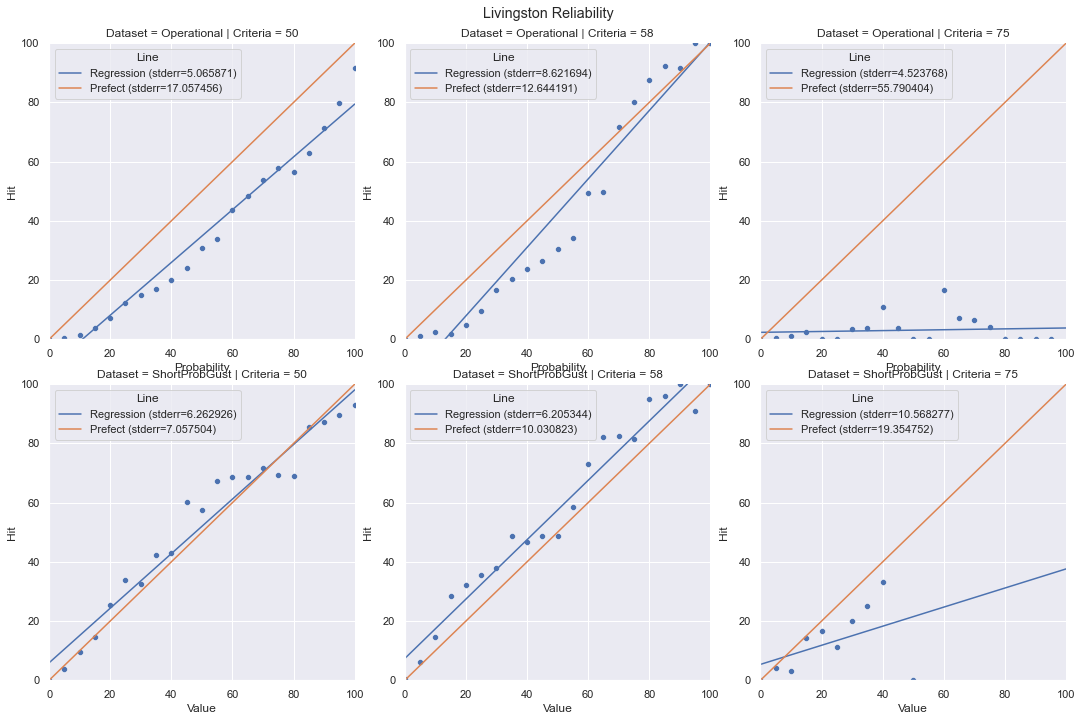

In [27]:
plot_data = reliability.copy(deep=True)
plot_data['Criteria'] = plot_data.Dataset.str.split('_', expand=True)[[1]]
plot_data.Dataset = plot_data.Dataset.str.split('_', expand=True)[[0]]


dataset_order = ['Operational', 'ShortProbGust']
dataset_order += [col for col in plot_data.columns if col not in dataset_order and col not in ['Dataset', 'Value', 'Hit', 'Criteria']]

plot_data = plot_data[plot_data.Dataset.apply(lambda a:a in dataset_order)]
g = sns.relplot(data=plot_data, x='Value', y='Hit', col='Criteria', row='Dataset', row_order=dataset_order, facet_kws=dict(ylim=(0,100), xlim=(0,100), sharex=False, sharey=False))
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Livingston Reliability')
for plot_vars, ax in g.axes_dict.items():
    method = '_'.join(plot_vars)
    if method in reliability_regressions.index:
        curve_data = pd.DataFrame({'Probability': np.array([0,100]),
               'Regression (stderr={0:f})'.format(reliability_regressions['stderr'][method]): reliability_regressions['slope'][method] * np.array([0,100]) + reliability_regressions['intercept'][method],
               'Prefect (stderr={0:f})'.format(reliability_regressions['stderr_perfect'][method]): np.array([0,100])}).melt(id_vars=['Probability'], var_name='Line', value_name='Hit')
        sns.lineplot(data=curve_data, x='Probability', y='Hit', hue='Line', ax=ax)
g.savefig('output/Livingston_ShortReliablity.png')

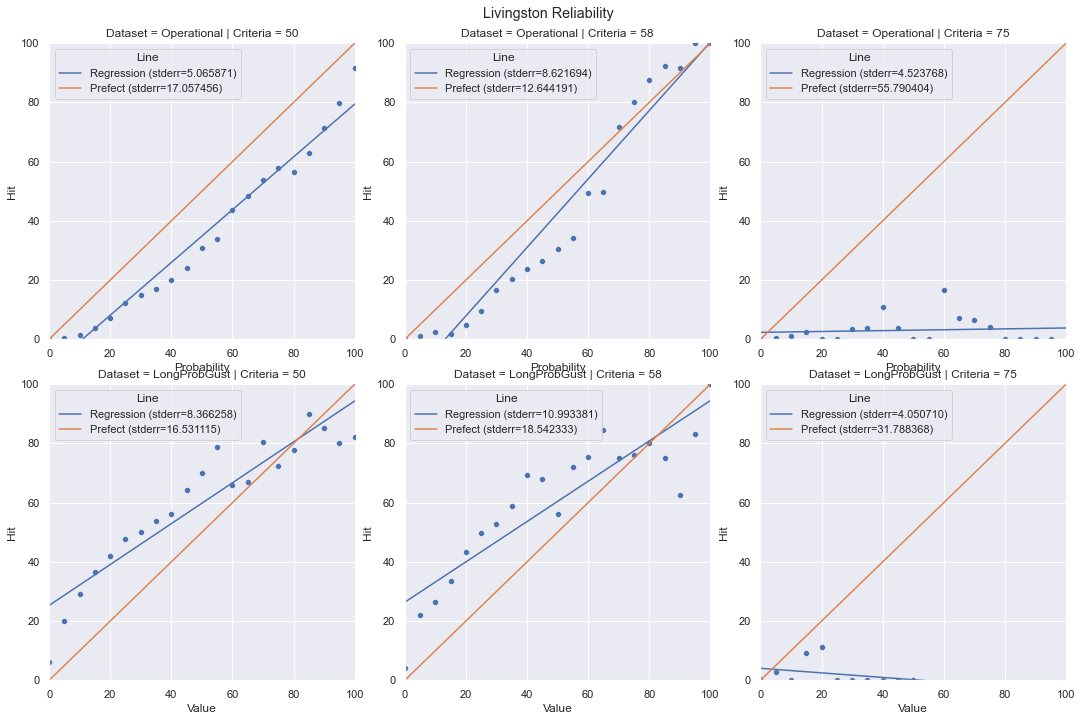

In [28]:
plot_data = reliability.copy(deep=True)
plot_data['Criteria'] = plot_data.Dataset.str.split('_', expand=True)[[1]]
plot_data.Dataset = plot_data.Dataset.str.split('_', expand=True)[[0]]


dataset_order = ['Operational', 'LongProbGust']
dataset_order += [col for col in plot_data.columns if col not in dataset_order and col not in ['Dataset', 'Value', 'Hit', 'Criteria']]

plot_data = plot_data[plot_data.Dataset.apply(lambda a:a in dataset_order)]
g = sns.relplot(data=plot_data, x='Value', y='Hit', col='Criteria', row='Dataset', row_order=dataset_order, facet_kws=dict(ylim=(0,100), xlim=(0,100), sharex=False, sharey=False))
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Livingston Reliability')
for plot_vars, ax in g.axes_dict.items():
    method = '_'.join(plot_vars)
    if method in reliability_regressions.index:
        curve_data = pd.DataFrame({'Probability': np.array([0,100]),
               'Regression (stderr={0:f})'.format(reliability_regressions['stderr'][method]): reliability_regressions['slope'][method] * np.array([0,100]) + reliability_regressions['intercept'][method],
               'Prefect (stderr={0:f})'.format(reliability_regressions['stderr_perfect'][method]): np.array([0,100])}).melt(id_vars=['Probability'], var_name='Line', value_name='Hit')
        sns.lineplot(data=curve_data, x='Probability', y='Hit', hue='Line', ax=ax)
g.savefig('output/Livingston_LongReliablity.png')